In [261]:
import seaborn as sns
import pandas as pd
from scipy.stats import fisher_exact
import numpy
import math

t = pd.read_csv('Supp_Table_combined_recessive_updated.tsv', sep='\t')
t.columns

Index(['Symbol', 'POL SNP cum. AF', 'POL SNP No. variants', 'POL SNP cum. AC',
       'POL SNP cum. AN', 'GnomAD NFE SNP cum. AF', 'GnomAD SNP No. variants',
       'GnomAD NFE SNP cum. AC', 'GnomAD NFE SNP cum. AN',
       'Cum. SNP AF fold change', 'P-value', 'POL SV deletion cum. AF',
       'POL SV duplication cum. AF', 'POL SV inversion cum. AF',
       'POL SV total cum. AF', 'gnomAD SV deletion cum. AF',
       'gnomAD SV duplication cum. AF', 'gnomAD SV inversion cum. AF',
       'gnomAD SV total cum. AF'],
      dtype='object')

In [262]:
t = t[['Symbol', 'POL SNP cum. AF', 'POL SNP cum. AC', 'POL SNP cum. AN', 
                 'GnomAD NFE SNP cum. AF', 'GnomAD NFE SNP cum. AC', 'GnomAD NFE SNP cum. AN', 
                 'P-value', 'Cum. SNP AF fold change']]
t.head()

,Symbol,POL SNP cum. AF,POL SNP cum. AC,POL SNP cum. AN,GnomAD NFE SNP cum. AF,GnomAD NFE SNP cum. AC,GnomAD NFE SNP cum. AN,P-value,Cum. SNP AF fold change
0,AAAS,0.000465,1,2152,0.000728,47,64598,1907.535492,-0.647379
1,AARS1,0.000000,0,2152,0.000015,1,64598,1968.000000,0.000000
2,AARS2,0.000929,2,2152,0.000728,47,64598,1968.000000,0.352405
3,AASS,0.000000,0,2152,0.000124,8,64598,1968.000000,0.000000
4,ABAT,0.000000,0,2152,0.000031,2,64598,1968.000000,0.000000


In [263]:
def get_fisher_exact_pvalue(row):
    pl = (int(row['POL SNP cum. AC']), 
          int(row['POL SNP cum. AN'])-int(row['POL SNP cum. AC']))
    nfe = (int(row['GnomAD NFE SNP cum. AC']), 
           int(row['GnomAD NFE SNP cum. AN'])-int(row['GnomAD NFE SNP cum. AC']))
    return fisher_exact((pl,nfe))[1]

t['fisher_p'] = t.apply(get_fisher_exact_pvalue, axis = 1)

## Filter by depth

In [264]:
ctc = pd.read_csv('depth_of_coverage_gene_aggregates.tsv', sep='\t')
ctc.head()

,symbol,min(mean_depth),avg(mean_depth),max(mean_depth),min(pct10x),avg(pct10x),max(pct10x),min(pct20x),avg(pct20x),max(pct20x)
0,SNORD115-48,38.53,38.529999,38.53,100.00,100.00,100.00,100.00,100.000000,100.00
1,PMS2P2,3.90,3.900000,3.90,21.91,21.91,21.91,0.00,0.000000,0.00
2,TSG1,36.57,36.570000,36.57,100.00,100.00,100.00,99.92,99.919998,99.92
3,DARS2,35.31,35.310001,35.31,100.00,100.00,100.00,99.94,99.940002,99.94
4,UBE2W,35.02,35.020000,35.02,100.00,100.00,100.00,99.87,99.870003,99.87


In [265]:
twc = t.merge(ctc, left_on='Symbol', right_on='symbol', how='left')
twc.shape

(2606, 20)

In [266]:
results_vs_coverage_data = pd.DataFrame({'results_no_coverage'   : len(twc[twc['avg(mean_depth)'].isna()]),
                                         'results_with_coverage' : len(twc[~twc['avg(mean_depth)'].isna()]),
                                         'results_mean_lt20'     : len(twc[twc['avg(mean_depth)'] < 20 ]),
                                         'results_mean_lt10'     : len(twc[twc['avg(mean_depth)'] < 10 ]),
                                         'results_avgpct20_lt90' : len(twc[twc['avg(pct20x)'] < 90 ]),
                                         'results_avgpct10_lt90' : len(twc[twc['avg(pct10x)'] < 90 ]),
                                         'results_minpct20_lt90' : len(twc[twc['min(pct20x)'] < 90 ]),
                                         'results_minpct10_lt90' : len(twc[twc['min(pct10x)'] < 90 ])},
                                       index=['count']).transpose()
results_vs_coverage_data

,count
results_no_coverage,76
results_with_coverage,2530
results_mean_lt20,7
results_mean_lt10,2
results_avgpct20_lt90,24
results_avgpct10_lt90,16
results_minpct20_lt90,24
results_minpct10_lt90,16


#### Depth cutoff 
All samples have __at least 90%__ of the transcript covered by __at least 20X__, or no coverage data available

In [268]:
twc['FILTER'] = ['PASS' if value>=90 or math.isnan(value) else 'LOW_DP' for value in twc['min(pct20x)']]
twc.head()

,Symbol,POL SNP cum. AF,POL SNP cum. AC,POL SNP cum. AN,GnomAD NFE SNP cum. AF,GnomAD NFE SNP cum. AC,GnomAD NFE SNP cum. AN,P-value,Cum. SNP AF fold change,fisher_p,...,min(mean_depth),avg(mean_depth),max(mean_depth),min(pct10x),avg(pct10x),max(pct10x),min(pct20x),avg(pct20x),max(pct20x),FILTER
0,AAAS,0.000465,1,2152,0.000728,47,64598,1907.535492,-0.647379,1.000000,...,38.99,38.990002,38.99,100.0,100.0,100.0,100.00,100.000000,100.00,PASS
1,AARS1,0.000000,0,2152,0.000015,1,64598,1968.000000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS
2,AARS2,0.000929,2,2152,0.000728,47,64598,1968.000000,0.352405,0.672275,...,36.77,36.770000,36.77,100.0,100.0,100.0,100.00,100.000000,100.00,PASS
3,AASS,0.000000,0,2152,0.000124,8,64598,1968.000000,0.000000,1.000000,...,35.84,35.840000,35.84,100.0,100.0,100.0,99.68,99.680000,99.68,PASS
4,ABAT,0.000000,0,2152,0.000031,2,64598,1968.000000,0.000000,1.000000,...,34.30,34.299999,34.30,100.0,100.0,100.0,97.88,97.879997,97.88,PASS


In [279]:
t = twc
t_pass = t[t.FILTER=='PASS']

## Compare p-values

In [280]:
#t['ratio'] = [math.log2(e+1e-10) for e in 
#                       ((t['POL SNP cum. AC']/t['POL SNP cum. AN']).astype(float) /
#                        (t['GnomAD NFE SNP cum. AC']/t['GnomAD NFE SNP cum. AN']).astype(float))]

t['pscaled_fisher_p'] = [-math.log10(e) for e in t['fisher_p'].astype(float)]
t['pscaled_P-value'] =  [0 if e == 0 else -math.log10(e) for e in t['P-value'].astype(float)]

t['diff'] = t['POL SNP cum. AF'].astype(float) - t['GnomAD NFE SNP cum. AF'].astype(float)
t['greater_AF_in'] = ['PL' if e > 0 else 'NFE' for e in t['diff'].astype(float)]

<AxesSubplot:xlabel='greater_AF_in', ylabel='pscaled_fisher_p'>

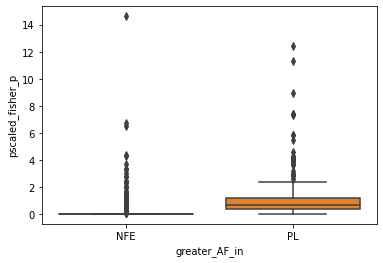

In [283]:
sns.boxplot(data=t_pass, x='greater_AF_in', y='pscaled_fisher_p', )

<AxesSubplot:xlabel='greater_AF_in', ylabel='pscaled_P-value'>

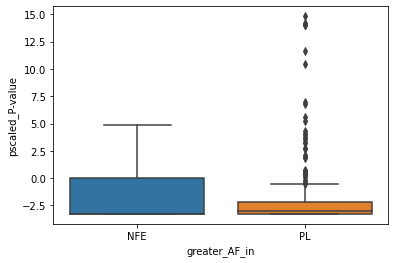

In [281]:
sns.boxplot(data=t_pass, y='pscaled_P-value', x='greater_AF_in')

<AxesSubplot:xlabel='pscaled_fisher_p', ylabel='pscaled_P-value'>

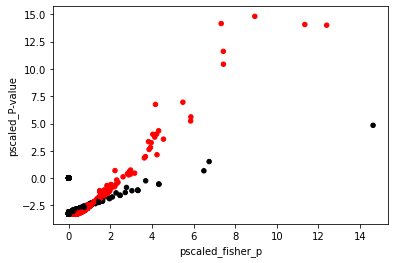

In [282]:
t_pass.plot.scatter(x='pscaled_fisher_p', y='pscaled_P-value', 
               c=["red" if e=='PL' else "black" for e in t_pass['greater_AF_in']])

In [284]:
t.sort_values('pscaled_fisher_p', ascending=False).head(30)

,Symbol,POL SNP cum. AF,POL SNP cum. AC,POL SNP cum. AN,GnomAD NFE SNP cum. AF,GnomAD NFE SNP cum. AC,GnomAD NFE SNP cum. AN,P-value,Cum. SNP AF fold change,fisher_p,...,avg(pct10x),max(pct10x),min(pct20x),avg(pct20x),max(pct20x),FILTER,pscaled_fisher_p,pscaled_P-value,diff,greater_AF_in
362,CBS,0.007064,15,2152,0.000215,14,64598,0.000000e+00,5.040133,2.040556e-15,...,5.250000,5.25,0.00,0.000000,0.00,LOW_DP,14.690252,0.000000,0.006849,PL
342,CADM3,0.000000,0,2152,0.016026,1035,64598,1.460350e-05,0.000000,2.387286e-15,...,99.389999,99.39,95.09,95.089996,95.09,PASS,14.622096,4.835543,-0.016026,NFE
323,C2,0.025116,54,2152,0.007558,488,64598,9.700000e-15,1.732517,4.036505e-13,...,100.000000,100.00,98.32,98.320000,98.32,PASS,12.393995,14.013228,0.017558,PL
2326,TGM5,0.017193,37,2152,0.004089,264,64598,8.400000e-15,2.072079,4.527952e-12,...,100.000000,100.00,100.00,100.000000,100.00,PASS,11.344098,14.075721,0.013104,PL
1644,NUP93,0.006970,15,2152,0.000743,48,64598,1.500000e-15,3.229029,1.144087e-09,...,100.000000,100.00,100.00,100.000000,100.00,PASS,8.941541,14.823909,0.006227,PL
820,F10,0.006506,14,2152,0.000852,55,64598,3.652570e-11,2.932342,3.684671e-08,...,100.000000,100.00,100.00,100.000000,100.00,PASS,7.433601,10.437401,0.005653,PL
1377,MASP1,0.005576,12,2152,0.000573,37,64598,2.424200e-12,3.282624,3.728691e-08,...,100.000000,100.00,100.00,100.000000,100.00,PASS,7.428444,11.615432,0.005003,PL
315,C19orf12,0.004203,9,2152,0.000248,16,64598,6.800000e-15,4.083944,4.736222e-08,...,100.000000,100.00,100.00,100.000000,100.00,PASS,7.324568,14.167491,0.003956,PL
1112,HTT,0.002367,5,2152,0.013387,865,64598,3.058262e-02,-2.499476,1.790274e-07,...,100.000000,100.00,99.45,99.449997,99.45,PASS,6.747080,1.514525,-0.011020,NFE
2193,SORD,0.005112,11,2152,0.000542,35,64598,1.183649e-10,3.237531,1.797430e-07,...,100.000000,100.00,87.84,87.839996,87.84,LOW_DP,6.745348,9.926777,0.004570,PL


In [285]:
t.sort_values('pscaled_fisher_p', ascending=False)\
 .to_csv('Supp_Table_combined_recessive_updated_PS.tsv', sep='\t', index=False)